## Set-up

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import pickle
from IPython.display import HTML

from moviepy.editor import VideoFileClip
import multiprocessing
from collections import deque
from sklearn.cluster import MeanShift

%matplotlib inline


/Users/sdegryze/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Auxiliary methods

In [2]:
def side_by_side(img1, img2, caption1, caption2, scale = 1):
    """Shows two images side-by-side with captions"""
    plt_fig = plt.figure(figsize=(20 * scale, 10 * scale))
    sub_plot = plt_fig.add_subplot(1, 2, 1)
    sub_plot.set_title(caption1)
    sub_plot.axis('off')
    plt.imshow(img1)
    sub_plot = plt_fig.add_subplot(1, 2, 2)
    sub_plot.set_title(caption2)
    sub_plot.axis('off')
    plt.imshow(img2)

def fun_side_by_side(fun, filename_1, filename_2):
    img1 = mpimg.imread(filename_1)
    img2 = mpimg.imread(filename_2)
    processed_1 = fun(img1)
    processed_2 = fun(img2)
    side_by_side(processed_1, processed_2, filename_1, filename_2)

In [3]:
def write_frames(framelist, prepend = "try_", filename="project_video.mp4"):
    """Writes specific frames from the project video. Frames are specified as indices in framelist."""
    vidcap = cv2.VideoCapture(filename)
    success, image = vidcap.read()
    count = 0
    success = True
    while success:
        success, image = vidcap.read()
        if (count + 3) in framelist:
            cv2.imwrite(prepend + str(count + 3) + ".jpg", image)     # save frame as JPEG file
        count += 1

## Feature extraction

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Classification

In [5]:
# Classification parameters - these should be tweaked t
# optimize the classification
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

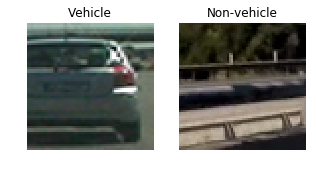

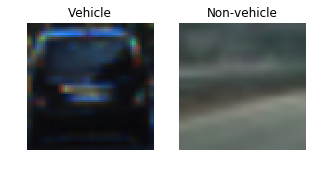

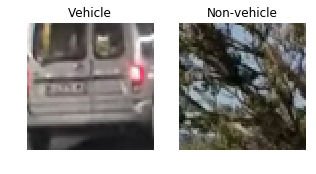

In [6]:
import random

# Read in cars and not-cars training data
cars = glob.glob('training-images/vehicles/*/*.png')
notcars = glob.glob('training-images/non-vehicles/*/*.png')

for i in range(3):
    side_by_side(plt.imread(cars[random.randint(0, len(cars))]),
                plt.imread(notcars[random.randint(0, len(cars))]),
                "Vehicle", "Non-vehicle", scale=0.25)

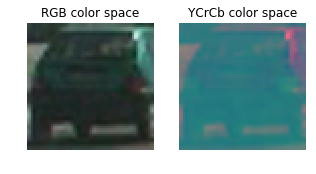

In [7]:
img = plt.imread(cars[random.randint(0, len(cars))])
img_proc = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
side_by_side(img, img_proc, "RGB color space", "YCrCb color space", scale=0.25)

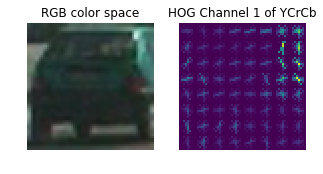

In [8]:
dummy, img_proc_hog = get_hog_features(img_proc[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
side_by_side(img, img_proc_hog, "RGB color space", "HOG Channel 1 of YCrCb", scale=0.25)

In [9]:
car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print("number of car images: ", len(cars))
print("number of not car images: ", len(notcars))

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
print('shape of X_train:', X_train.shape)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

number of car images:  8792
number of not car images:  8968
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
shape of X_train: (14208, 6108)
16.25 Seconds to train SVC...
Test Accuracy of SVC =  0.9862


## Predicting cars within 1 video frame

In [10]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [11]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def hog_closure(channel):
    return(get_hog_features(channel, orient, pix_per_cell, cell_per_block, feature_vec=False))
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,
              hist_bins, parallel=False):
    on_windows = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if parallel:
        hog1, hog2, hog3 = multi_proc_pool.map(hog_closure, [ch1, ch2, ch3])
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((xbox_left, ytop_draw + ystart),
                                   (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                #cv2.rectangle(draw_img,,(),(0,0,255),6) 
                
    return on_windows

def find_cars_closure(arg_list):
    return(find_cars(arg_list[0], 400, arg_list[1], arg_list[2], svc, X_scaler, orient, pix_per_cell,
                     cell_per_block, spatial_size, hist_bins))
    
def get_hot_windows_opt(image, parallel=False):

    hot_windows_1 = find_cars(image, 400, 475, 0.75, svc, X_scaler, orient, pix_per_cell,
                              cell_per_block, spatial_size, hist_bins, parallel)
    hot_windows_2 = find_cars(image, 400, 525, 1.5, svc, X_scaler, orient, pix_per_cell,
                              cell_per_block, spatial_size, hist_bins, parallel)
    hot_windows_3 = find_cars(image, 400, 600, 2.0, svc, X_scaler, orient, pix_per_cell,
                              cell_per_block, spatial_size, hist_bins, parallel)
    hot_windows = hot_windows_1 + hot_windows_2 + hot_windows_3
    return hot_windows

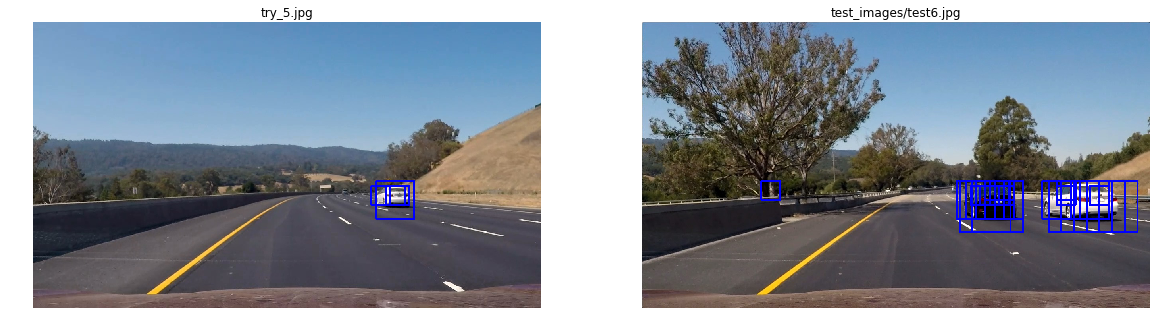

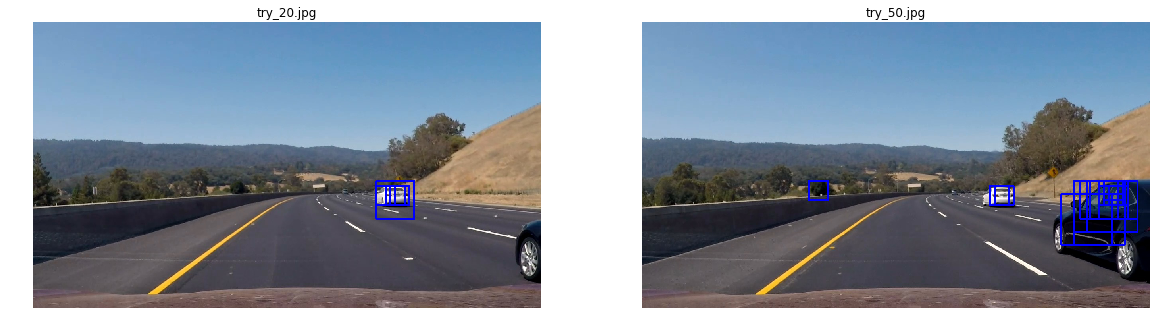

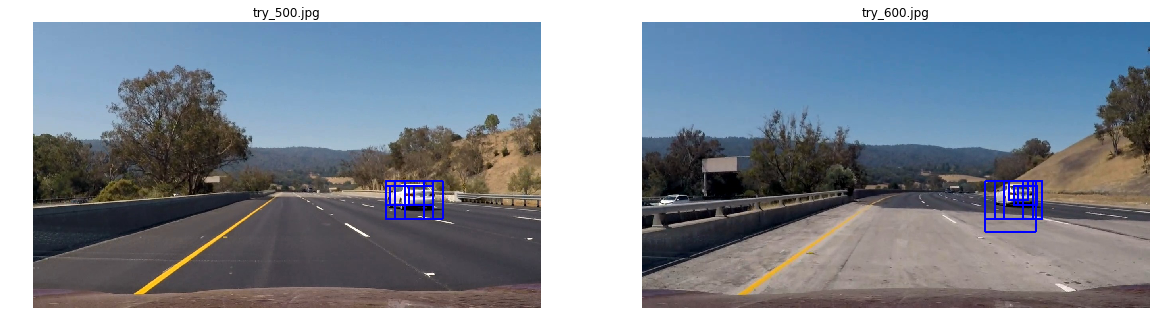

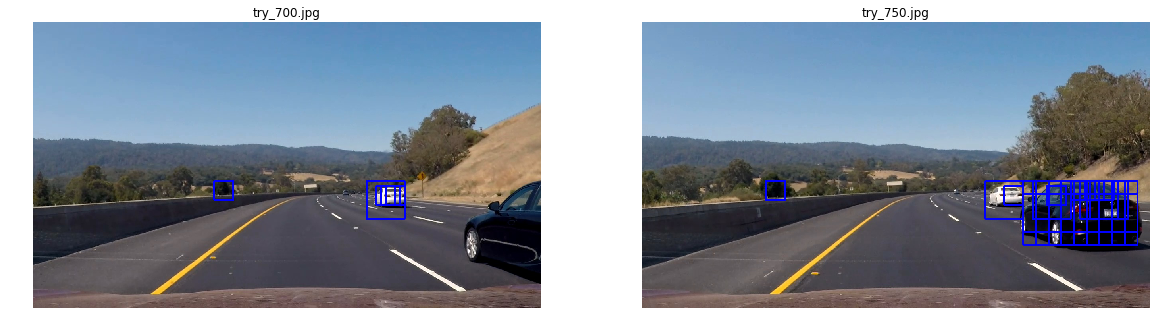

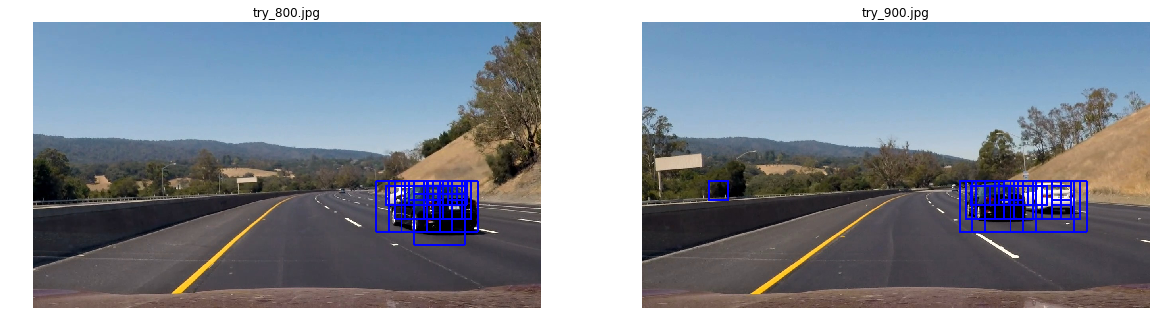

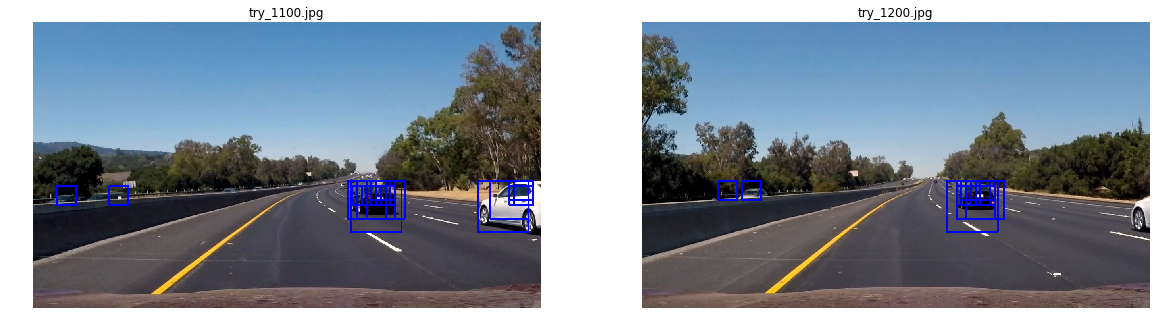

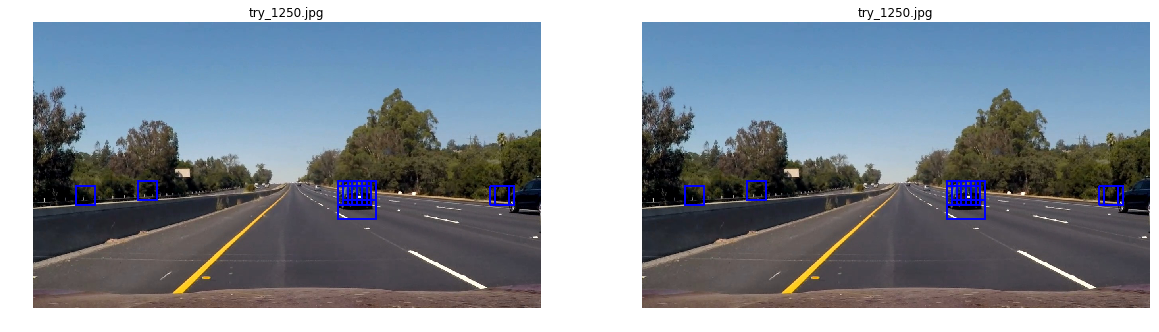

In [12]:
def hot_and_draw(input_image):
    hot_windows = get_hot_windows_opt(input_image, parallel=True)
    processed = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=3)
    return(processed)

if __name__ == '__main__':
    multi_proc_pool = multiprocessing.Pool(12)
    
fun_side_by_side(hot_and_draw, 'try_5.jpg', 'test_images/test6.jpg')
fun_side_by_side(hot_and_draw, 'try_20.jpg', 'try_50.jpg')
fun_side_by_side(hot_and_draw, 'try_500.jpg', 'try_600.jpg')
fun_side_by_side(hot_and_draw, 'try_700.jpg', 'try_750.jpg')
fun_side_by_side(hot_and_draw, 'try_800.jpg', 'try_900.jpg')
fun_side_by_side(hot_and_draw, 'try_1100.jpg', 'try_1200.jpg')
fun_side_by_side(hot_and_draw, 'try_1250.jpg', 'try_1250.jpg')

There are many overlapping windows, so in a next step we will combine the overlapping windows and also apply a filter for false positives.

## Removing false positives by summing detection windows

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def get_heat(input_image, hot_windows, threshold=3):
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    return(heatmap)

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In the following cell, I calculate a heatmap for 6 consecutive frames.

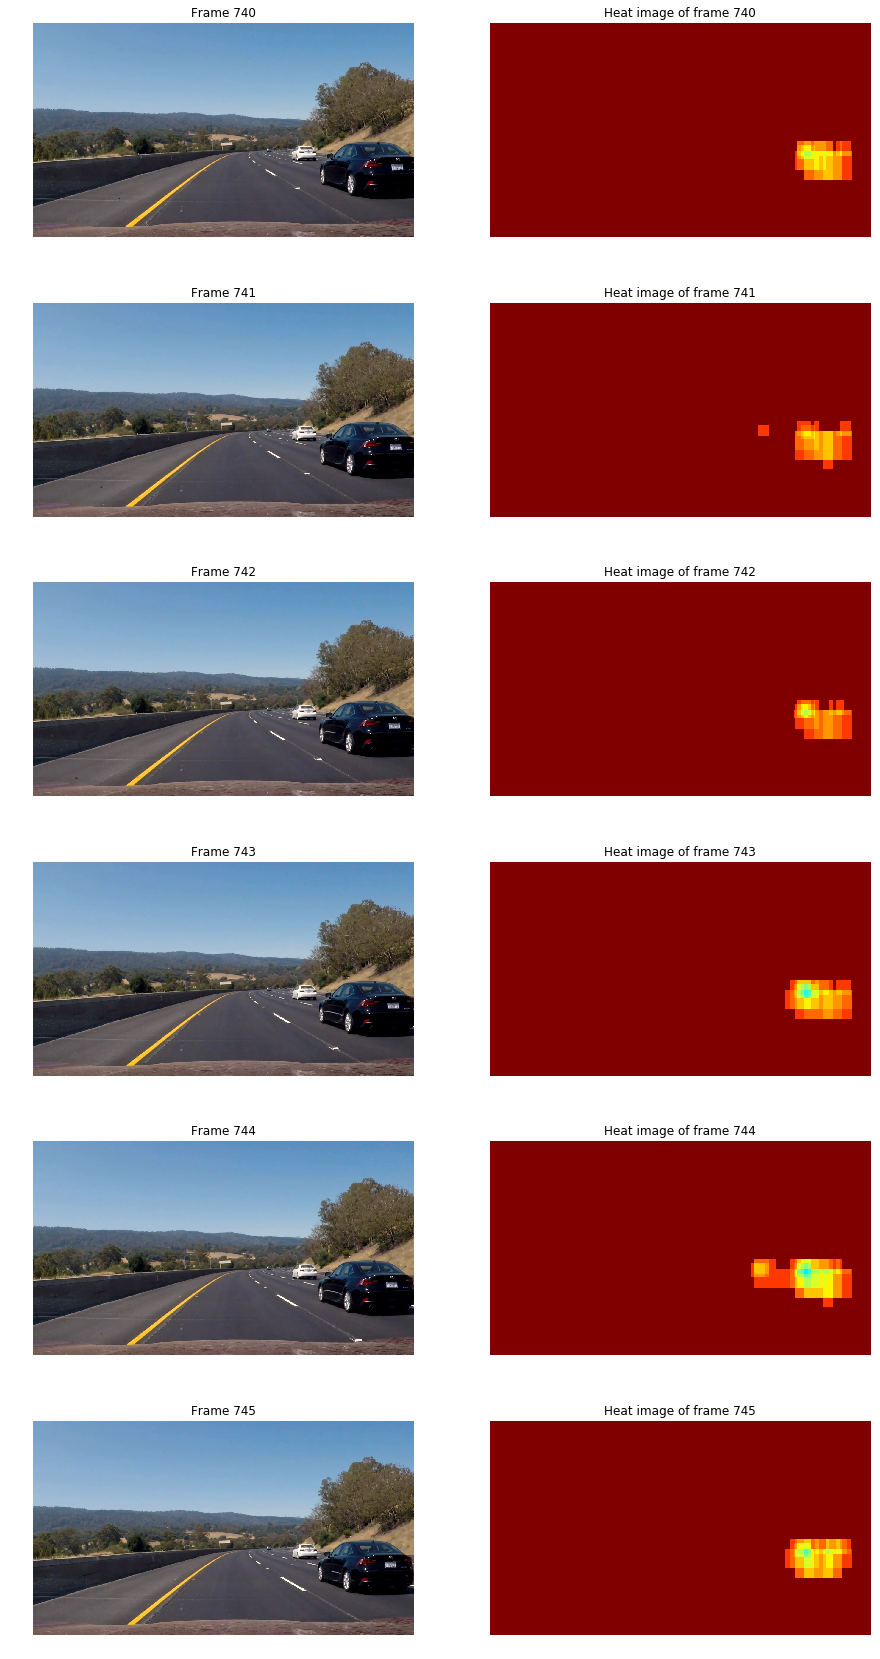

In [14]:
frames = [740, 741, 742, 743, 744, 745]
len_frames = len(frames)

images = [plt.imread("try_" + str(frame_nr) + ".jpg") for frame_nr in frames]
heat_images = [get_heat(img, get_hot_windows_opt(img)) for img in images]

plt_fig = plt.figure(figsize=(15, 5 * len_frames))

for idx, frame_nr in enumerate(frames):
    sub_plot = plt_fig.add_subplot(6, 2, idx * 2 + 1)
    sub_plot.set_title("Frame " + str(frame_nr))
    sub_plot.axis('off')
    plt.imshow(images[idx])
    
    heat_img = heat_images[idx]
    heat_img_3 = cv2.applyColorMap((heat_img/15*175).astype(np.uint8), cv2.COLORMAP_JET)
    sub_plot = plt_fig.add_subplot(6, 2, idx * 2 + 2)
    sub_plot.set_title("Heat image of frame " + str(frame_nr))
    sub_plot.axis('off')
    plt.imshow(heat_img_3)

## Combine bounding boxes to avoid multiple bounding boxes shown on the same car

Before I do something with the heatmaps, I will introduce a method to combine close bounding boxes into one box to avoid having multiple bounding boxes shown in the same car. I need to explain this before the next section because the approach is integrated in the `draw_labeled_bboxes` function, which is used in the next step.

In [15]:
def centroid(bbox):
    "Centroid of 4 corner points of a bbox"
    return([(bbox[0][0] + bbox[1][0]) / 2., (bbox[0][1] + bbox[1][1]) / 2.])

def combine_boxes(bboxes, bandwidth=150):
    """Combines boxes within a list of bboxes according to the distances of their centroids"""
    if len(bboxes) > 1:
        centroids = [centroid(bbox) for bbox in bboxes]
        centroids_np = np.array(centroids)
        labels = MeanShift(bandwidth = bandwidth).fit(centroids_np).labels_
        combined_boxes = []
        for label in range(1 + np.max(labels)):
            boxes_in_label = [box for idx,box in enumerate(bboxes) if labels[idx] == label]
            top_left_x = min(box[0][0] for box in boxes_in_label)
            top_left_y = min(box[0][1] for box in boxes_in_label)
            bottom_right_x = max(box[1][0] for box in boxes_in_label)
            bottom_right_y = max(box[1][1] for box in boxes_in_label)
            combined_box = ((top_left_x, top_left_y), (bottom_right_x, bottom_right_y))
            combined_boxes.append(combined_box)
        return(combined_boxes)
    else:
        return(bboxes)

def draw_labeled_bboxes(img, labels):
    """Draws labele bboxes on a frame. This function was modified from the original class function by
    adding logic to combine boxes."""
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    bboxes = combine_boxes(bboxes)
    # Return the image
    for bbox in bboxes:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img


def sum_and_find_box(input_image):
    # Find final boxes from heatmap using label function
    hot_windows = get_hot_windows_opt(input_image)
    heat_img = get_heat(input_image, hot_windows)
    labels = label(heat_img)
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    return(draw_img)

The `combine_boxes` method was modified to cluster nearby boxes together. This is done with the `MeanShift` clustering method in sklearn. The bandwidth parameter controls how aggressive the clustering is. In the example below, we are applying this approach to the bounding boxes **before** the heatmap calculation. This is just for illustrative purposes. In the final processing pipeline, first the heat map calculation and labeling is applied, and only then the bounding box clustering.

Note that a simple k-means clustering method was not used since one needs to provide the number of clusters as an input to this algorithm. With `MeanShift`, one does not need to do that. Instead, the `bandwidth` parameter specifies the critical distance above which two centroids should be in different clusters.

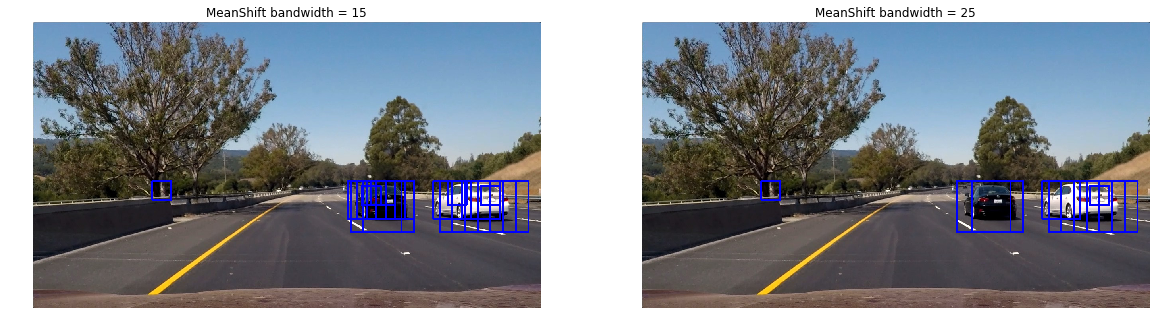

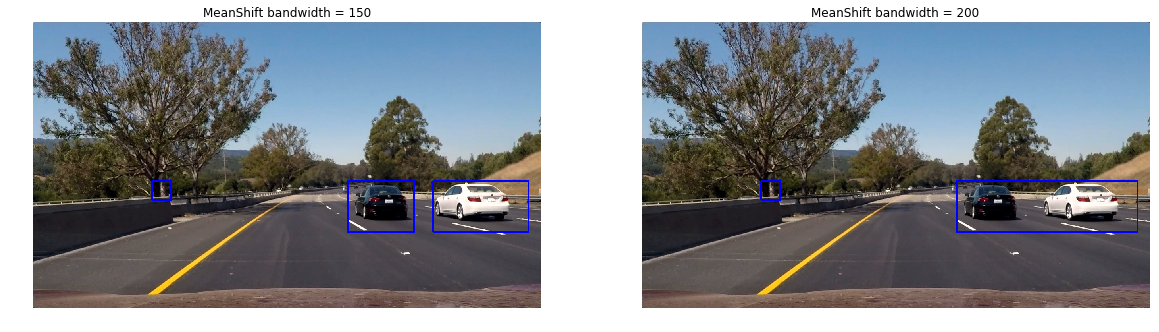

In [16]:
input_image = mpimg.imread("test_images/test6.jpg")
hot_windows = get_hot_windows_opt(input_image, parallel=True)
hot_windows_combined_15 = combine_boxes(hot_windows, bandwidth=15)
hot_windows_combined_25 = combine_boxes(hot_windows, bandwidth=25)
hot_windows_combined_150 = combine_boxes(hot_windows, bandwidth=150)
hot_windows_combined_200 = combine_boxes(hot_windows, bandwidth=200)
db_closure = lambda w: draw_boxes(input_image, w, color=(0, 0, 255), thick=3)
side_by_side(db_closure(hot_windows_combined_15), db_closure(hot_windows_combined_25),
            "MeanShift bandwidth = 15", "MeanShift bandwidth = 25")
side_by_side(db_closure(hot_windows_combined_150), db_closure(hot_windows_combined_200),
            "MeanShift bandwidth = 150", "MeanShift bandwidth = 200")

## Using thresholding and labeling to find robust bounding boxes for cars

Let's see how the combined heat-map calculation, labeling, and box clustering looks like on a few example frames.

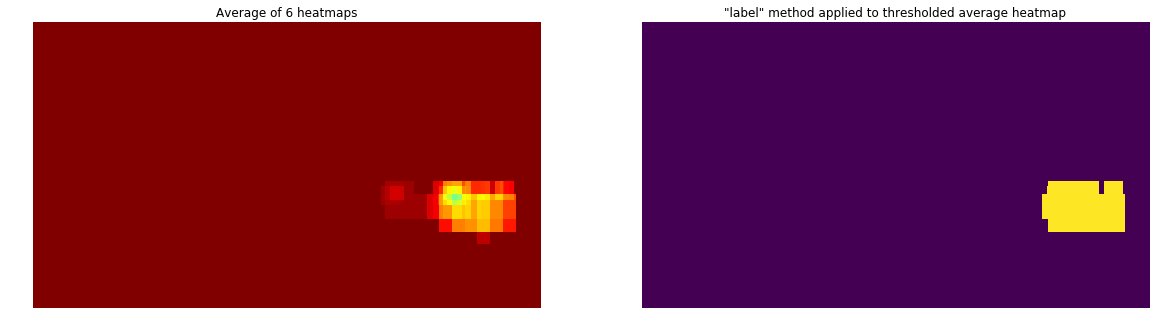

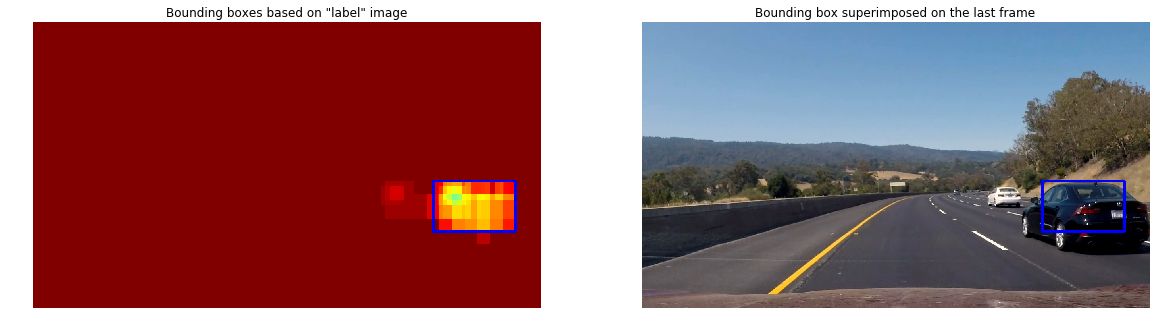

In [17]:
avg_heat = np.sum(np.array(heat_images)/6, axis=0)
avg_heat_3 = cv2.applyColorMap((avg_heat/15*175).astype(np.uint8), cv2.COLORMAP_JET)
labels = label(apply_threshold(avg_heat, 2))
heat_img_w_box = draw_labeled_bboxes(np.copy(labels[0]), labels)
side_by_side(avg_heat_3,
             labels[0],
             "Average of 6 heatmaps",
             "\"label\" method applied to thresholded average heatmap")

side_by_side(draw_labeled_bboxes(np.copy(avg_heat_3), labels),
             draw_labeled_bboxes(np.copy(images[5]), labels),
             "Bounding boxes based on \"label\" image",
             "Bounding box superimposed on the last frame")

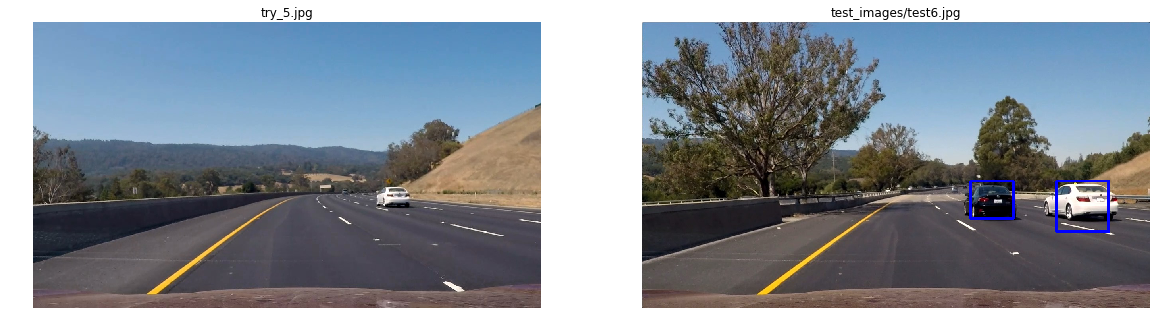

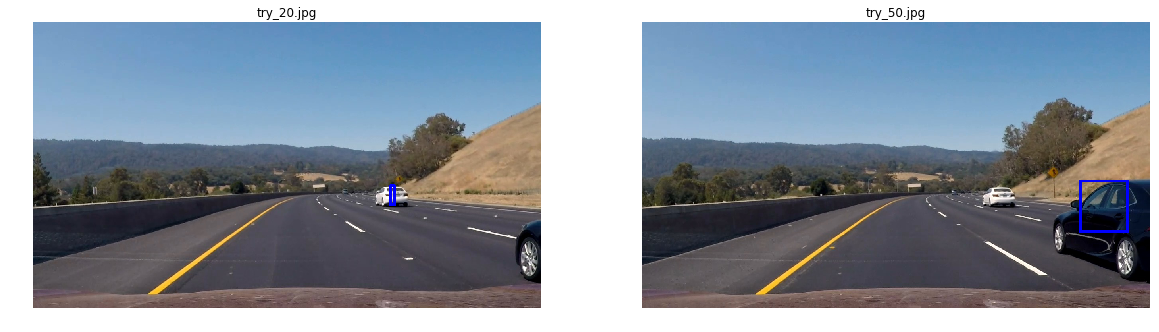

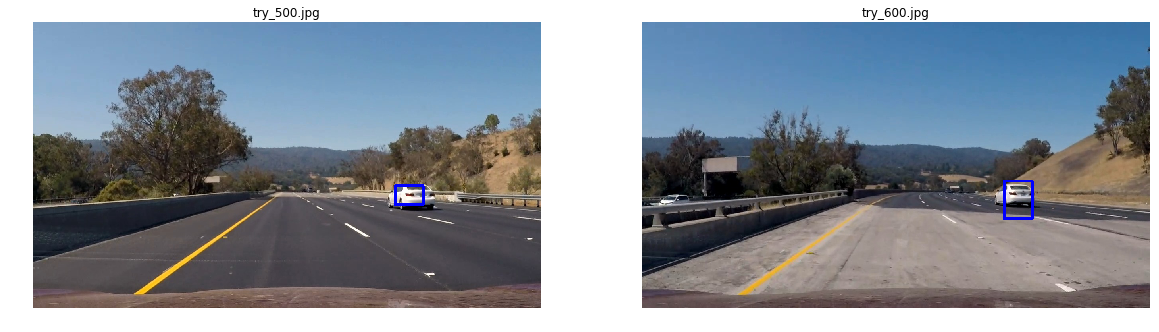

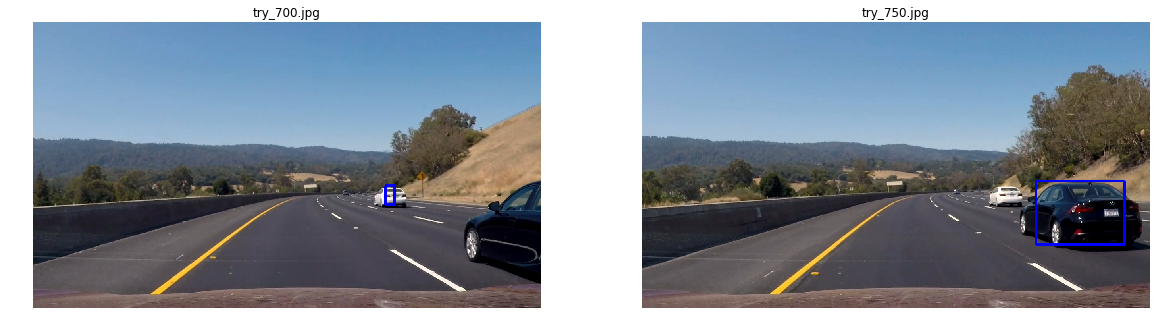

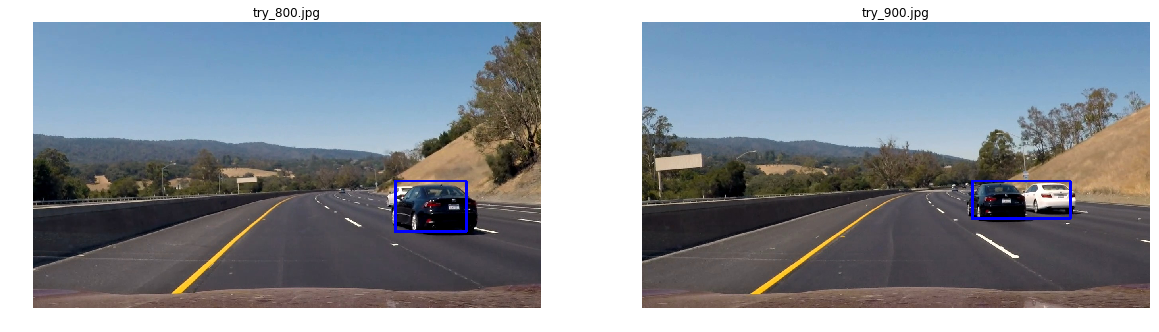

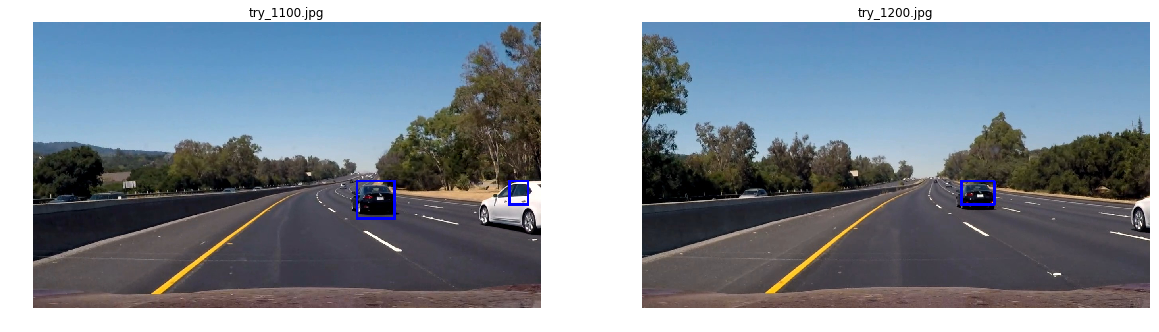

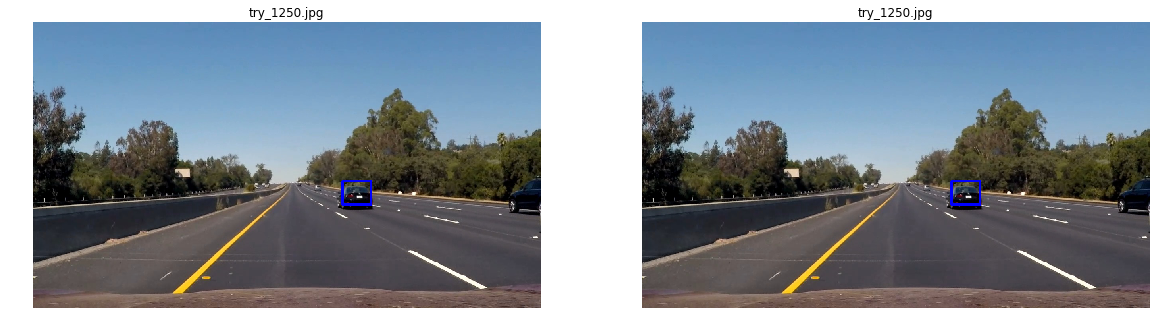

In [18]:
fun_side_by_side(sum_and_find_box, 'try_5.jpg', 'test_images/test6.jpg')
fun_side_by_side(sum_and_find_box, 'try_20.jpg', 'try_50.jpg')
fun_side_by_side(sum_and_find_box, 'try_500.jpg', 'try_600.jpg')
fun_side_by_side(sum_and_find_box, 'try_700.jpg', 'try_750.jpg')
fun_side_by_side(sum_and_find_box, 'try_800.jpg', 'try_900.jpg')
fun_side_by_side(sum_and_find_box, 'try_1100.jpg', 'try_1200.jpg')
fun_side_by_side(sum_and_find_box, 'try_1250.jpg', 'try_1250.jpg')

## Applying classifier on a videostream and averaging detection windows in consecutive frames

We are calculating the running average of the heat map using a `deque`. This is a fast and appropriate data structure.

In [19]:
class VehicleDetector():
    def __init__(self, nr_frames=6):
        """nr_frames is the number of frames over which an average should be calculated"""
        # read in a dummy image to get the right dimensions of the video feed
        dummy_image = mpimg.imread('test_images/test6.jpg')
        self.sum_heat = np.zeros_like(dummy_image[:,:,1], dtype = np.float64)
        
        self.nr_frames = nr_frames
        
        # This deque object is used to calculate a running average of the last nr_frames
        # (i.e., 15 by default)
        # The thresholding is based on this running average to reduce the occurrence of a
        # false positive
        self.heat_maps = deque(maxlen = nr_frames)
        self.frame_nr = 0
        
    
    def process_frame(self, input_image):
        hot_windows = get_hot_windows_opt(input_image, parallel=False)
        heat = get_heat(input_image, hot_windows, threshold=1)
        
        # For performance reasons, we are not continuously calculating the average over
        # the 15 images in the deque. Instead, we are keeping track of the sum of pixels
        # of the last 15 images and update the sum by adding a new image and removing
        # the frame from 15 frames before using popleft()
        self.sum_heat += heat
        
        if self.frame_nr >= self.nr_frames:
            self.sum_heat -= self.heat_maps.popleft()
        
        self.heat_maps.append(heat)
        self.frame_nr += 1
        
        avg_heat = self.sum_heat / min(self.frame_nr, self.nr_frames)
        
        # Apply threshold to help remove false positives
        # The higher this value, the less false positives, but the higher
        # The incidence of false negatives as well
        # This value was optimized manually
        avg_heat = apply_threshold(avg_heat, 2)

        # Find final boxes from heatmap using label function
        labels = label(avg_heat)
        draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
        return(draw_img)
            

In [20]:
# The following lines are needed to make sure the parallel computation works from within a jupyter notebook.
if __name__ == '__main__':
    multi_proc_pool = multiprocessing.Pool(12)

vd = VehicleDetector()
output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

output_clip = clip.fl_image(vd.process_frame)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [11:39<00:00,  1.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 10min 46s, sys: 1min 6s, total: 11min 52s
Wall time: 11min 39s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))